# Retain Customers with Time to Event Modeling Driven Intervention
## Pinpointing Customer Churn at the Right Time using XGBoost

It usually costs more to acquire a customer than it does to retain a customer.

Focusing on customer retention enables companies to maximize customer revenue over their lifetime.

This blog post will show you how to train a model to predict both the risk **and the time** of a customer attrition event using [XGBoost](https://github.com/dmlc/xgboost).

Combined with a [production-level end-to-end Machine Learning pipeline](https://towardsdatascience.com/deploying-a-scalable-end-to-end-customer-churn-prediction-solution-with-aws-cbf3536be996) like [Customer Churn Pipeline on AWS
](https://github.com/awslabs/aws-customer-churn-pipeline) that has time to event churn modeling baked in, this allows for timely interventions to stop attrition.

<img src="CustomerLifeCycle.png" width="500" height="200">

Customer attrition or simply [churn](https://en.wikipedia.org/wiki/Customer_attrition) is when a customer 'leaves' before maximal revenue is achieved. Stopping these events to retain revenue is so established that churn-based models are one of the very first machine learning solutions that go into production.

However, these models are seldom done optimally as they rely on binary classification flags (churn yes or no). Churn classification models do not tell **WHEN** a customer is likely to leave but only indicate that it’s going to happen within a certain number of days or months.

This blog post will present how to measure churn risk **during a customer's lifecycle** to find the **point in time** churn intervention is needed.

## Paradigm Shift: from Event Only to Timely Intervention

A good reason churn models could be better is that many are set on arbitrary time threshold for a fixed binary outcome.
This means that time is held constant!
For example, setting an arbitrary threshold that after 40 days of inactivity a customer churns.

Flagging customers based on such heuristics leads to slippage, mainly:

* Customers churning before the threshold.
* Customers that churn far, far after the threshold.
* Ignores customer lifetime differences

It is probably a mistake to treat a customer that is at risk of leaving in 40 days the same as a customer that remains for over a 100 days. Traditional churn modeling does not make this differentiation. 

For example, in the chart below, Customer B is captured accurately by the model because they leave at the exact point in time that the threshold was set (40 days). Customer A actually churns after the threshold and they are lost because the model is not able to account for them. Customer C did the opposite, staying on far longer than the data time window. They will most likely churn but we cannot model for when with a classification model.

<img src="TraditionalChurn.png" width="500" height="200">

The only point in time here is the "within 40 days" threshold. As it fails to account for time, we have no clear idea at what point a marketing intervention is needed and it causes preventable customer attrition.

### Re-framing the Problem to Know *When*

Rather then use a binary classifier, we are going to re-frame the problem as time-dependent one. This enables us to intervene at the right time to stop customer attrition before it happens.

No longer relying on thresholds, we now set churn as continuous time conditioned event.

As the below graph shows, we now know the **time** that attrition **risk** is most likely to happen.

<img src="InterventionChurn.png" width="500" height="200">

No longer is time held constant, we now track risk **over time** to determine when a marketing intervention is needed to retain the customer.

If we model for both the time and event, the right moment to intervene and prevent attrition is apparent.

A modeling technique called [Survival Analysis](https://en.wikipedia.org/wiki/Survival_analysis) allows for us to do this and with the advent of modern Machine Learning, it's now a trivial task.

A dive deep of Survival Analysis and the maths behind, is out scope and we encourage you to look at all the [great posts on Medium's Toward Data Science for more information](https://towardsdatascience.com/search?q=survival).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import xgboost as xgb
import shap
import sksurv.metrics as surv_metrics
from sksurv.datasets import get_x_y
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import DataConversionWarning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler



plt.rcParams['figure.figsize'] = [7.2, 4.8]
pd.set_option("display.float_format", lambda x: "%.4f" % x)

sns.set_style('darkgrid')

SEED = 123

## A Quick Glimpse at the Data

In this example, you will use a synthetic churn dataset for an imaginary telecommunications company with the outcome Churn? flagged as as either True (churned) or False (did not churn). Features include customer details such as plan and usage information. The churn dataset is publicly available and mentioned in the book [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/). It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [2]:
df = pd.read_csv("../../data/churn.txt")

# clean up the column names
new_col_names = [s.lower().replace(" ","_").replace("'","") for s in df.columns.tolist()]
df.columns = new_col_names

# remove id and set area code as categorical
del df['phone']
df['area_code'] = df['area_code'].astype('category')

# denoting churn and duration
df["event"] = np.where(df["churn?"] == "False.", 0, 1)
df = df.rename(columns={"account_length": "duration"})

del df['churn?']

df = df.dropna()
df = df.drop_duplicates()

In [3]:
df.head()

,state,duration,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,event
0,PA,163,806,no,yes,300,8.1622,3,7.5792,3.9330,4,6.5086,4.0658,100,5.1116,4.9282,6,5.6732,3,1
1,SC,15,836,yes,no,0,10.0190,4,4.2263,2.3250,0,9.9726,7.1410,200,6.4362,3.2217,6,2.5597,8,0
2,MO,131,777,no,yes,300,4.7085,3,4.7682,4.5375,3,4.5667,5.3632,100,5.1425,7.1390,2,6.2542,4,0
3,WY,75,878,yes,yes,700,1.2687,3,2.5676,2.5287,5,2.3336,3.7736,450,3.8144,2.2458,6,1.0807,6,0
4,WY,146,878,yes,no,0,2.6962,3,5.9089,6.0153,3,3.6704,3.7517,250,2.7968,6.9055,4,7.1343,6,1


Examining our targets further shows that, there are a total of 5,000 records of which 49.9% end up churning.

The dataset is balanced on the target. In real world data, this is not always the case and a churn event could be 1% out of millions records.

There's strategies to remedy that but it's out of scope for this blog post.

Looking at the duration, represented as the Account Length (our time component), it shows that the median time is 102 days, which is close to the average of 101 days.

In [4]:
print("Total Records:",df.shape[0],"\n")
print("Percent Churn Rate:",df.event.mean())
print("")
print("Duration Intervals")
print(df['duration'].describe())

Total Records: 5000 

Percent Churn Rate: 0.4996

Duration Intervals
count   5000.0000
mean     101.6758
std       57.5968
min        1.0000
25%       52.0000
50%      102.0000
75%      151.0000
max      200.0000
Name: duration, dtype: float64


For Survival models data is different form traditional classification problem and requires:

* A Censor - For our purposes these are customers who've yet to churn. [Read about right censoring here](https://en.wikipedia.org/wiki/Survival_analysis#Censoring).
* Duration - The duration or time $t$ of the customer's activity. In this case, it's `Account Length` in days.
* Event - The binary target, in this case if they terminated their phone plan marked by `Churn?`.

We can plot the first 10 customers on timeline to understand how [right censored](https://en.wikipedia.org/wiki/Censoring_(statistics)#:~:text=Right%20censoring%20%E2%80%93%20a%20data%20point,subjects%20remaining%20are%20right%2Dcensored.) data works and the problem is framed.

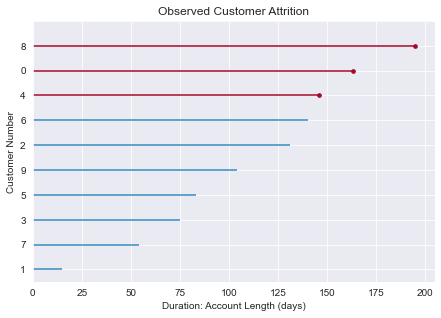

In [5]:
ax = plot_lifetimes(df.head(10)['duration'], df.head(10)['event'])

_=ax.set_xlabel("Duration: Account Length (days)")
_=ax.set_ylabel("Customer Number")
_=ax.set_title("Observed Customer Attrition")

In the above plot, the red lines indicates when a customer has left with the dots indicating the specific point in time.
Blue lines are customers that are still active up to the time measured on the x-axis in Duration. 

Here we see that customer number 8 did not attrit until up to 195 days, with customer numbers 0 and 4 leaving in 163 and 146 days respectively.  All other customers are still active.

Notice how all customers are set on the same time scale because the data is **analytically aligned**.
 
Each customer might have come in at different times but we've set the days as the same. This is what allowed us to right-censor the data on the churn event.

Real world data needs both censoring and aligning before modeling can begin.

### The Risk of Churn

A more informative approach might be to estimate the [Survival Function](https://en.wikipedia.org/wiki/Survival_function) or the time in days a customer has until they attrit.

For this purpose, we will use a [Kaplan Meier Estimator](http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) to calculate how long until attrition occurs.

The estimator is defined as:

$$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$$

Where 𝑑𝑖 are the number of churn events at time 𝑡 and 𝑛𝑖 is the number of customers at risk of churn just prior to time 𝑡.

We will use the great [python package lifelines](https://github.com/CamDavidsonPilon/lifelines) to do plot the Survival Function as the function is a component of the final churn model.

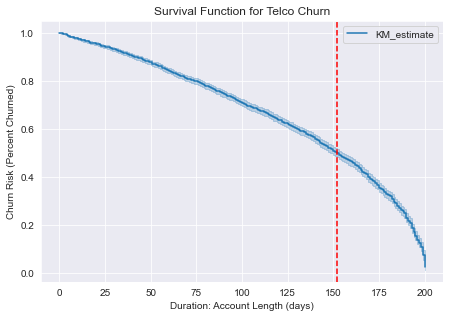

In [6]:
kmf = KaplanMeierFitter()

kmf.fit(df['duration'], event_observed=df['event'])

kmf.plot_survival_function()
_=plt.title('Survival Function for Telco Churn');
_=plt.xlabel("Duration: Account Length (days)")
_=plt.ylabel("Churn Risk (Percent Churned)")
_=plt.axvline(x=kmf.median_survival_time_, color='r', linestyle='--')

Let's look at the median survival time. This is the point by which half of customers have churned out.

According to this graph, where it's marked by the red dotted line, by about 152 days half of customers churn.

This is helpful because it gives *overall* baseline when intervention is needed.

However, for each individual customer this is uninformative.

What is missing is **the point in time** in which churn risk is highest for *each* customer.

For that we will create a model using [Cox's Proportional Hazard](https://en.wikipedia.org/wiki/Survival_analysis#Cox_proportional_hazards_(PH)_regression_analysis) which uses a log-risk function $h(x)$.

The Hazard function is conditioned on rate of a customers remaining until time t or later, this allows to estimate the risk of churn **overtime**.

This will enable us to score **each customer** and anticipate when a marketing intervention is needed.

However, before we proceed to that, we need to preprocess the data.

## Data Splitting and Preprocessing

First we will split the data into training and testing. We'll use the testing set as the validation for the example.
In practice, you want all three of these splits so that you don't tune to the validation set.

Next, we take the numeric features and categorical features and then preprocess them for downstream modeling.

In the case of categories, we will first impute with the constant and then simply one-hot encode them.

In the case of numerics, we will fill with the median then standardize them between values of 0 and 1.

This is all wrapped into Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer) for simplicity's sake.

As part of the [Churn Pipeline](https://github.com/awslabs/aws-customer-churn-pipeline) all these steps are included with the final preprocessor saved for use at inference time.

In [7]:
df_train, df_test = train_test_split(df , test_size=0.20, random_state=SEED)

In [8]:
numerical_idx = (
        df_train.select_dtypes(exclude=["object", "category"])
        .drop(['event','duration'],1)
        .columns.tolist()
    )

categorical_idx = df_train.select_dtypes(exclude=["float", "int"]).columns.tolist()

numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(sparse=False, handle_unknown="ignore")),
        ]
    )

preprocessor = ColumnTransformer(
        [
            ("numerical", numeric_transformer, numerical_idx),
            ("categorical", categorical_transformer, categorical_idx),
        ],
        remainder="passthrough",
    )

train_features = preprocessor.fit_transform(df_train.drop(['event','duration'],1))
test_features = preprocessor.transform(df_test.drop(['event','duration'],1))

### Converting the Traget for XGBoost

We will use the [DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix) format for XGBoost to run through the regular, non-scikit API.

In the case of using the survival function - this requires a transformation of the predictor.

For vanilla XGBoost this entails setting duration as the target and then making it positive for events and negative for non-events.

Rather than having a tuple of event and duration, this gives your positive/negative single continuous variable as the target.

Lastly extract feature names from our pipeline for later use in model explainability.

For more about how Survival works in XGBoost see this [tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/aft_survival_analysis.html). 

In [9]:
def survival_y_cox(dframe:pd.DataFrame) -> np.array:
    """Returns array of outcome encoded for XGB"""
    y_survival = []

    for idx, row in dframe[["duration", "event"]].iterrows():
        if row["event"]:
            # uncensored
            y_survival.append(int(row["duration"]))
        else:
            # right censored
            y_survival.append(-int(row["duration"]))
    return np.array(y_survival)

In [10]:
feature_names = np.hstack((np.array(numerical_idx),
                           preprocessor.transformers_[1][1]['onehot'].get_feature_names()))

dm_train = xgb.DMatrix(
    train_features, label=survival_y_cox(df_train), feature_names=feature_names
)

dm_test = xgb.DMatrix(
    test_features, label=survival_y_cox(df_test), feature_names=feature_names
)

## More on the Hazard Function

The hazard function provides customer attrition **risk** - telling us when churn is most likely to happen.

Whereas the Survival function S(t) returns the probability of churn beyond a point of time $S(t) = P(T > t)\$, the Hazard function h(t) instead gives an approximate probability of that customer stays up to the time t such that:

$$h(t) = \lim_{\Delta t \rightarrow 0} \frac{P(t \leq T &lt; t + \Delta t \mid T \geq t)}{\Delta t} \geq 0 .\$$

On a side note, with the Hazard function, it is also possible to get the survival function because:

$\begin{equation*}
S(t) = \exp\left(- \int_{0}^{t} h(u) du \right)
\end{equation*}$

## Gradient Boosting and Cox’s Partial Likelihood

In the case of Gradient Boosting multiple base learners are combined to obtain boosted overall ensemble of learners defined as an additive model of:

$\begin{equation}
f(\mathbf{x}) = \sum_{m=1}^M \beta_m g(\mathbf{x}; {\theta}_m),
\end{equation}$

For the Survival analysis case, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model $f(x)$ with the additive model:

$\begin{equation}
  \arg \min_{f} \quad \sum_{i=1}^n \delta_i \left[ f(\mathbf{x}_i)
- \log \left( \sum_{j \in \mathcal{R}_i} \exp(f(\mathbf{x}_j)) \right) \right] 
\end{equation}$

For more on this see this [excellent tutorial for python library Scikit-Survival](https://scikit-survival.readthedocs.io/en/latest/user_guide/boosting.html).

The normal parameters all apply here with the exception that we've changed the `objective` to `surivial:cox` this will allow for training a boosted survival tree.

In [16]:
params = {
    "eta": 0.1,
    "max_depth": 3, 
    "objective": "survival:cox",
    "tree_method": "hist",
    "subsample": 0.8,
    "seed": 123
}
bst = xgb.train(
    params,
    dm_train,
    num_boost_round=300,
    evals=[(dm_train, "train"), (dm_test, "test")],
    verbose_eval=int(1e1),
    early_stopping_rounds=10
)

[0]	train-cox-nloglik:7.25501	test-cox-nloglik:5.86755
[10]	train-cox-nloglik:7.00306	test-cox-nloglik:5.59962
[20]	train-cox-nloglik:6.91366	test-cox-nloglik:5.49806
[30]	train-cox-nloglik:6.86444	test-cox-nloglik:5.44991
[40]	train-cox-nloglik:6.83705	test-cox-nloglik:5.43687
[50]	train-cox-nloglik:6.81648	test-cox-nloglik:5.42424
[60]	train-cox-nloglik:6.79757	test-cox-nloglik:5.42385
[70]	train-cox-nloglik:6.78127	test-cox-nloglik:5.41936
[80]	train-cox-nloglik:6.75929	test-cox-nloglik:5.41047
[90]	train-cox-nloglik:6.74249	test-cox-nloglik:5.40701
[100]	train-cox-nloglik:6.73142	test-cox-nloglik:5.40504
[110]	train-cox-nloglik:6.71863	test-cox-nloglik:5.40143
[120]	train-cox-nloglik:6.70495	test-cox-nloglik:5.39802
[130]	train-cox-nloglik:6.69283	test-cox-nloglik:5.39483
[140]	train-cox-nloglik:6.68125	test-cox-nloglik:5.39092
[150]	train-cox-nloglik:6.67124	test-cox-nloglik:5.39253
[151]	train-cox-nloglik:6.67063	test-cox-nloglik:5.39344


### A Note On Predictions

Predictions for this model are are returned on the hazard ratio scale. 

(i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).

This means that the output can come out either as the exponentiated marginal prediction or as the non-exponentiated version.

For predicting when churn is most likely to occur we will want the exponentiated version as it intuits to a probability (even though it's not really one technically speaking).

For more on this see [how output happens see](https://datascience.stackexchange.com/questions/52097/what-is-the-outcome-of-a-cox-regression-in-xgboost).

In [17]:
%%capture 

df_test.loc[:,"preds"] = bst.predict(dm_test, output_margin=True) 
df_test.loc[:, "preds_exp"] = bst.predict(dm_test, output_margin=False) 

We can then take the scores Hazard scores or the probability of churn conditioned on time $t$ (in this case Account Length), and look at overall when churn is most likely to occur.

Bucketing the values into time periods shows that the highest churn risk happens at days 53 to 62.

Following this period, the most likely times for attrition are at days 80 to 102.

In practice, you should ignore the final bar from days 191 to 200 as this is the point of truncation.

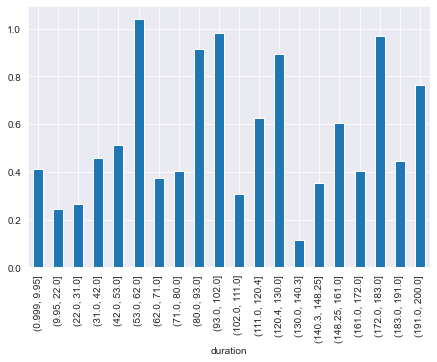

In [18]:
_=df_test.groupby(pd.qcut(df_test['duration'], q=20))['preds_exp'].median().plot(kind="bar")

# Evaluating Performance

In the case of Surivavl Models [Harrell’s Concordance Index](https://statisticaloddsandends.wordpress.com/2019/10/26/what-is-harrells-c-index/) and [Brier Score](https://en.wikipedia.org/wiki/Brier_score) are commonly used to evaluate survival models.


### Harrell’s Concordance Index (Harrell et al. 1982)

The **concordance index** or **C-index** is a generalization of the [area under the ROC curve (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) that can take into account censored data. 

It should be thought of as a goodness of fit measure for models which baselines the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. 

**Values of *C = 0.5* indicate that risk scores are no better than a coin flip.**

This is expressed as as the # of concordiant pairs / (# of concordiant pairs + # of discordiant pairs) or:

$$\begin{equation}
    \text{C-index} = \frac{ \sum_{i, j} \mathbb{1}_{T_j < T_i} \cdot \mathbb{1}_{\eta_j > \eta_i} \cdot \delta_j }{\sum_{i, j} \mathbb{1}_{T_j < T_i}\cdot \delta_j }
\end{equation}$$

with:
$\eta_i$, the risk score of a unit $i$ 
$\mathbb{1}_{ T_j < T_i } = 1$ if $T_j < T_i$ else $0$ 
$\mathbb{1}_{ \eta_j > \eta_i } =  1$ if  $\eta_j > \eta_i$ else $0$ 

### Brier Score (Brier 1950)

The Brier score is used to evaluate the accuracy of a predicted survival function at a given time $t$ it represents the <em>average squared distances between the observed survival status and the predicted survival probability and is always a number between 0 and 1, with 0 being the best possible value. 

**The lower the Brier score is for a set of predictions, the better the predictions are calibrated.**
**An acceptable baseline is 0.25**

Given a dataset of N samples,  $$\forall i \in  [\![1, N ]\!],  \left(\vec{x}_i, \delta_i, T_i \right)$$ is the format of a datapoint, and the predicted survival function is $$\hat{S}(t, \vec{x}_i), \forall t \in \mathbb{R^+}$$

In the absence of right censoring, the Brier score can be calculated such that:
        $$\begin{equation}
            BS(t) = \frac{1}{N} \sum_{i = 1}^{N} (\mathbb{1}_{ T_i > t } - \hat{S}(t, \vec{x}_i))^2
        \end{equation}$$

However, if the dataset contains samples that are right censored, then it is necessary to adjust the score by weighting.

That's where [Scikit-Survival's Brier Score metric](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.brier_score.html) comes to the rescue.

As stated in their docs, the time-dependent Brier score is the mean squared error at time point t

$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(y_i \leq t \land \delta_i = 1)
\frac{(0 - \hat{\pi}(t | \mathbf{x}_i))^2}{\hat{G}(y_i)} + I(y_i > t)
\frac{(1 - \hat{\pi}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$

where $\hat{\pi}(t | \mathbf{x})$ is the predicted probability of
remaining event-free up to time point $t$ for a feature vector $x$,
and $1/\hat{G}(t)$ is an inverse probability of censoring weight, estimated by
the Kaplan-Meier estimator.

That means the measurement is now adjusted for right censored data, and is thus more accurate.

Let's score the model!

In [19]:
_, y_train = get_x_y(df_train,['event','duration'],pos_label=True)
_, y_test = get_x_y(df_test,['event','duration'],pos_label=True)

del _

print("CIC")
print(
    surv_metrics.concordance_index_ipcw(
       y_train,
       y_test,
      df_test['preds'],
        tau=100 # within 100 days
    )
)

print("")
print("Brier Score")

times, score = surv_metrics.brier_score(
y_train,y_test, df_test['preds'], df_test['duration'].max() - 1
)
print(score)


CIC
(0.7514910949902487, 177342, 58706, 0, 1218)

Brier Score
[0.37630957]


These results are okay given that the data was not prepared with survival analysis in mind :)
    
The Concordance Index comes out to 0.74 which is better than simple random chance.

The Brier Score is 0.33 which is not so great. Ideally, we'd want it to be 0.25 or lower as the [Pysurvival documentation indicates](https://square.github.io/pysurvival/metrics/brier_score.html).

There are other ways to evaluate this further.

For example, the [Scikit-survival](https://github.com/sebp/scikit-survival) package offers a wide variety of metrics for evaluation such as the [Time dependent Area under the ROC](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html#Time-dependent-Area-under-the-ROC) and more.

# Model Explainability with SHAP

The good news is that [SHAP (SHapley Additive exPlanations](https://github.com/slundberg/shap)  provides a high-speed exact algorithm for tree-based ensembles to help explain feature importance within the model.

Specifically, it will allow for use to understand what raises and lowers attrition risk for customers.

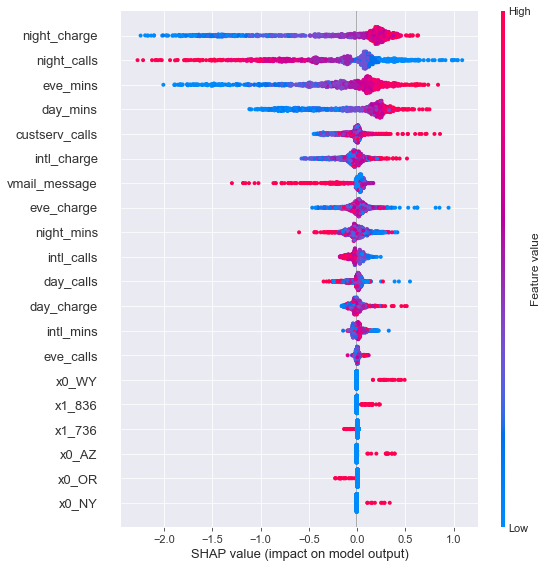

In [20]:
explainer = shap.TreeExplainer(bst, feature_names=feature_names)
shap_values = explainer.shap_values(test_features) 

shap.summary_plot(shap_values, pd.DataFrame(test_features, columns=feature_names))

Moreover, we now have an explanation at the customer level of how each churn risk score is calculated. 
This can help inform intervention strategies choices. For example, night charges, night calls and evening minutes all drive customer attrition. Adding in the daily minutes (as a positive predictor) shows that clearly customers making calls in the evening or at night are at higher risk. This could go into an intervention strategy by setting intervention communications to go out to at risk customers during the night and evening.


This provides details that are easy to show for business users and ways in which to further analyze what features drive customer attrition.

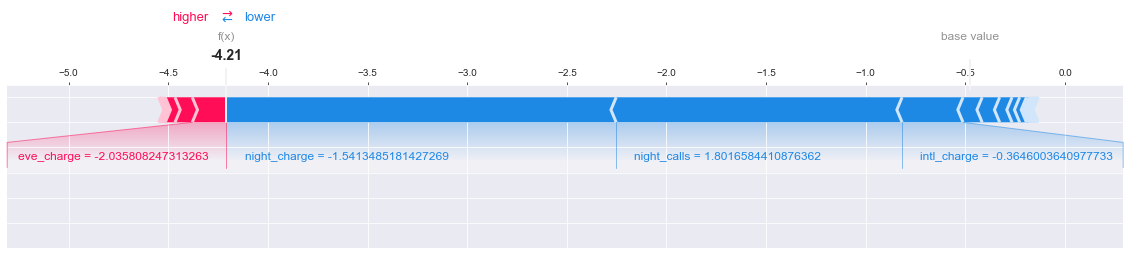

The real label is Churn=False


In [21]:
idx_sample = 128
shap.force_plot(
    explainer.expected_value,
    shap_values[idx_sample, :],
    pd.DataFrame(test_features, columns=feature_names).iloc[idx_sample, :],
    matplotlib=True,
)

print(f"The real label is Churn={y_test[idx_sample][0]}")

Lastly, since this is a tree-based model we can also plot what the tree(s) look like.

Though we set up to 100 trees to train, early stopping set in and the best iteration for the run was 67 trees.

Let's just take the first tree and look at it's splits to judge to understand how inference is run.

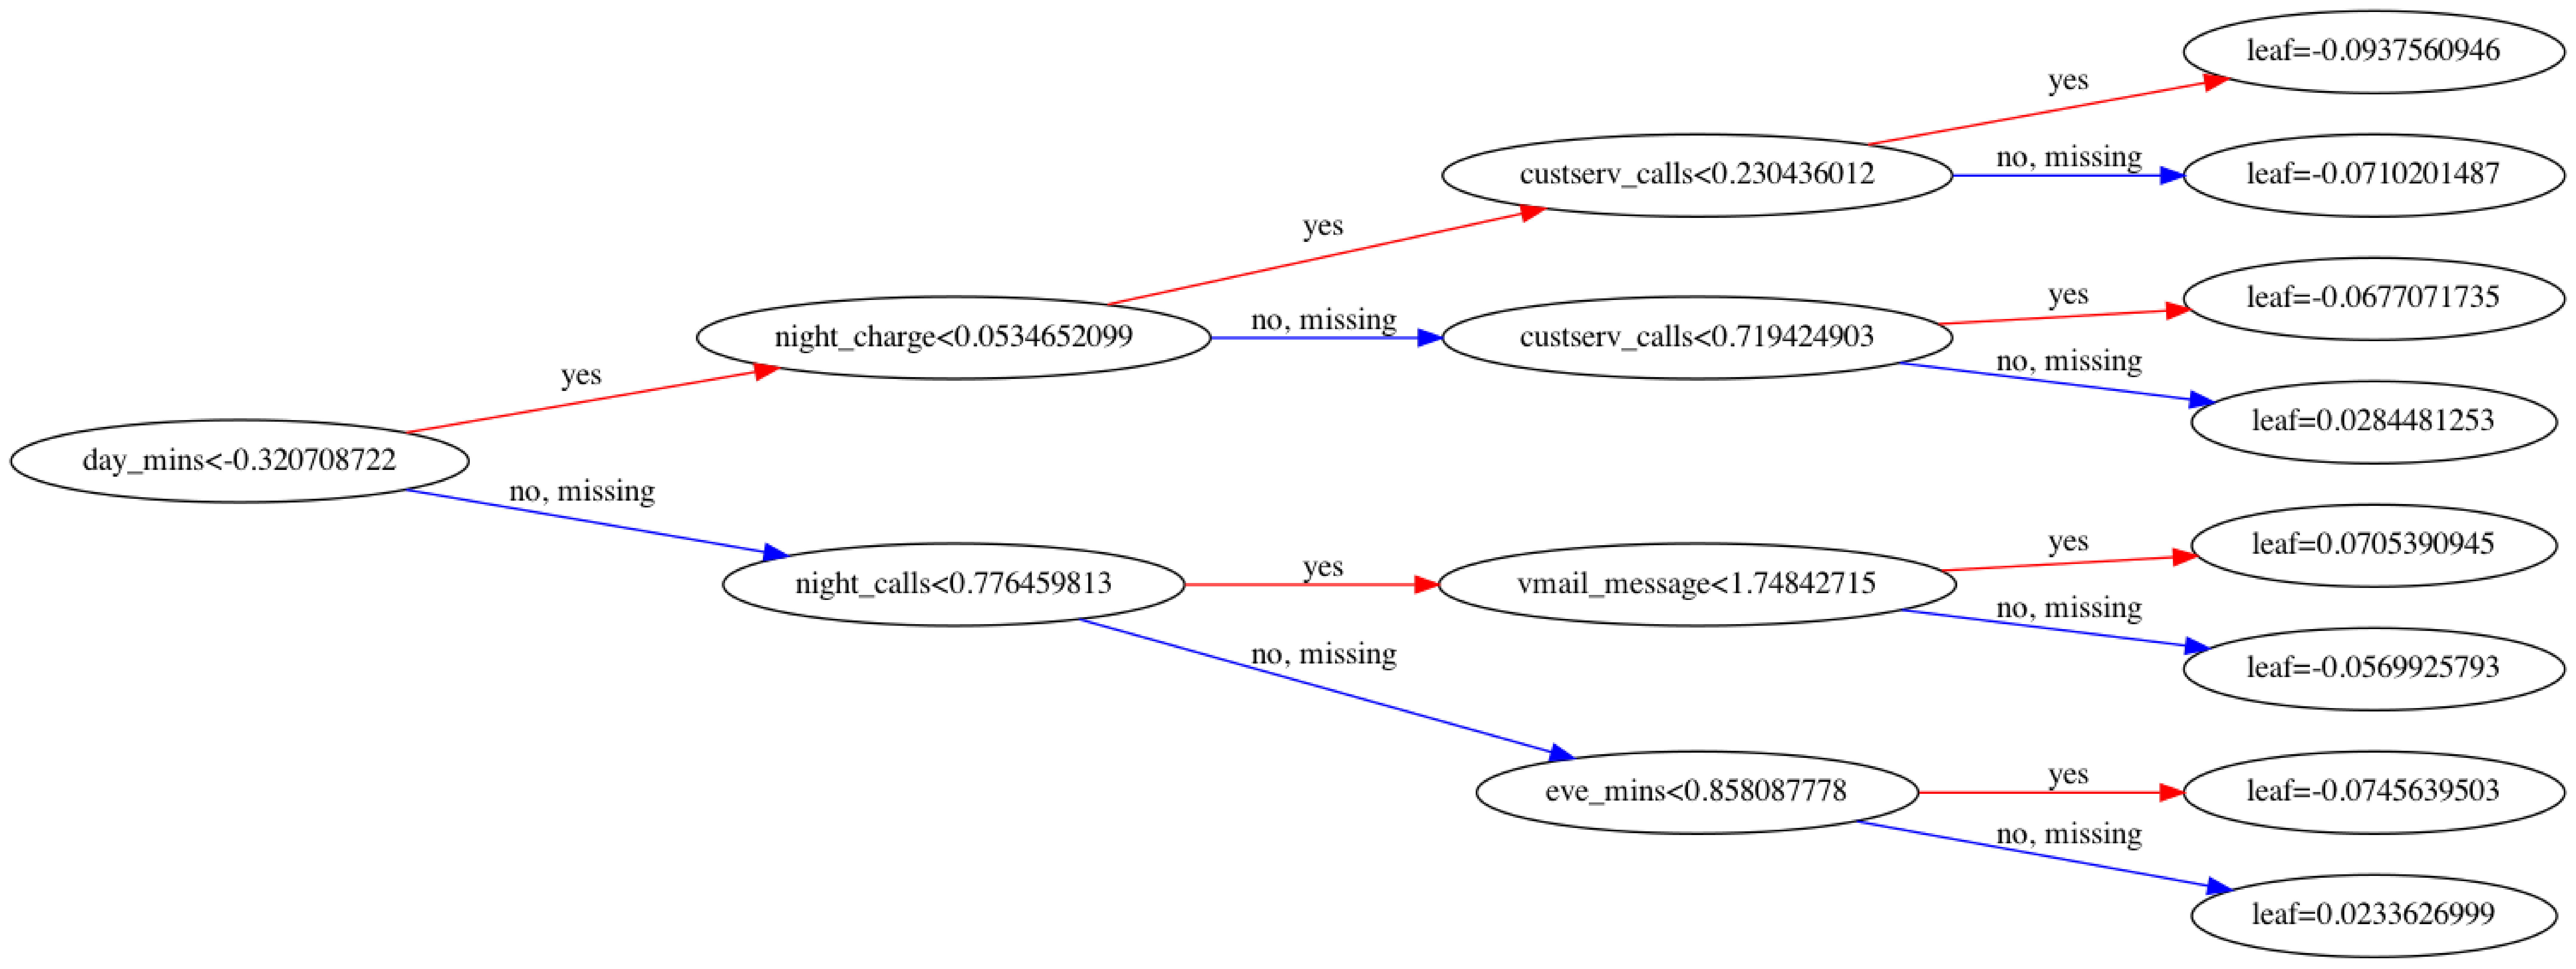

In [34]:
xgb.plot_tree(bst, rankdir="LR", num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig("tree.png", bbox_inches="tight")

Unsurprisingly, the most predictive features are the ones that it split on first.

In this case, that means night charge, night calls, day minutes and evening minutes.

Obviously, this tree also is a great way to demonstrate what your model is doing for business users to understand.

# The Final Check

For our final check we will treat the problem as a classifier just because we can.

Since the model itself is conditioned on time, these aren't really good metrics to evaluate how *technically* well it's doing.

We are simply running this for the naysayers and to show that it works.

In [35]:
from sklearn import metrics

y_preds = df_test.preds.apply(lambda x : np.exp(x))
y_pred = np.where(y_preds > 0.5, 1, 0)

print(f"Accuracy score: {metrics.accuracy_score(df_test.event, y_pred)}")
print(f"Area Under the Curve {metrics.roc_auc_score(df_test.event, y_pred)}")
print("")
print(metrics.classification_report(df_test.event, y_pred))

Accuracy score: 0.932
Area Under the Curve 0.9339674490815218

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       527
           1       0.89      0.97      0.93       473

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



Amazingly, the model gets better results then the [reported 86% accuracy when this dataset first appeared in the blogosphere in 2017](https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/).

Not only do we have accuracy but we can identify **WHEN**.
This allows for timely marketing intervention to retain customers. 

## Conclusion

This blog post showed how to train a churn model with a time component.

Using the Survival Analysis with Cox Proportional Hazard allows us circumvent customer attrition by pinpointing when it's risk is the highest.

This allows for a proactive, point in time intervention to stop customers from leaving.

Now that you have model a it's time to work on productionizing like with the [Customer Churn Pipeline on AWS](https://github.com/awslabs/aws-customer-churn-pipeline) which includes a template for Time to Event modeling for churn. 

Once the pipeline is configured, you can run inference on records over time accumulating scores with batch inference to make intervention decisions.

In [22]:
scores = np.random.normal(size=30).reshape(3,10)
scores_df = pd.DataFrame(scores
                         , index=['Customer A', 'Customer B',' Customer C']
                         , columns=[10,20,30,40,50,60,70,80,90,100])
scores_df

,10,20,30,40,50,60,70,80,90,100
Customer A,1.0816,-0.2466,0.9721,0.1023,-0.9279,-0.3164,-1.2483,-0.0722,1.1304,2.0311
Customer B,-0.7480,-1.6873,3.0243,0.4243,-0.3449,0.6505,0.7276,-0.4460,0.6338,-1.2768
Customer C,0.0329,0.0069,1.4743,-0.1613,-1.6458,1.0538,0.4379,0.0361,-2.1493,-0.7862


(The above show a table accumulated results of batch jobs by customer over days. There is now a churn risk history of the customer to monitor and flag when to intervene)


The use of Machine Learning for Survival Analysis is a great way to frame problems such as churn.
We encourage you to look at the references links below for all the different techniques that are available.

## References

[Lifelines, Cameron Davidson-Pilon](https://github.com/CamDavidsonPilon/lifelines)

[XGBoost: A Scalable Tree Boosting System, Chen & Guestrin 2016](https://github.com/dmlc/xgboost)

[PySurvival: Open source package for Survival Analysis modeling, Fotso 2019](https://github.com/square/pysurvival/)

[scikit-survival: A Library for Time-to-Event Analysis Built on Top of scikit-learn, Sebastian Polsterl 2020](https://github.com/sebp/scikit-survival)

[SHAP (SHapley Additive exPlanations), Lundberg 2017](https://github.com/slundberg/shap)